# Classic Control: Control theory problems from the classic RL literature

<br><br>

In this notebook we will present some classic environments in Reinforcement Learning research. These environments have continuous states spaces (i.e., infinite possible states) and therefore tabular methods cannot solve them. To tackle these environments (and more complex ones) we will have two tools:

- Extend the tabular methods with the techniques of discretization and tile coding
- Use function approximators (Neural Networks)



<br><br><br>
<div style="text-align:center">
    <b>This notebook belongs to the course "Reinforcement Learning: beginner to master".</b>
    <br><br>
    <a href="https://www.udemy.com">Reinforcement Learning: beginner to master</a> (English)
    <br>
    <a href="https://www.udemy.com">Reinforcement Learning: de principiante a maestro</a> (Spanish)
</div>

<br>

<table style="width:35%">
  <tr style="background-color: transparent">
    <td style="width: 45%">
        <a target="_parent" href="https://www.evlabs.io" style="float: center">
            <img src="img/evlabs-square.png" width="75"/>
        </a> 
    </td>
    <td valign="bottom">
        <a target="_parent" href="https://www.youtube.com/channel/UCksRNSzWuMV5IfdrPlglqqw">
            <img src="img/YouTube.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://www.linkedin.com/company/evlabs">
            <img src="img/LinkedIn.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://twitter.com/evelabs">
            <img src="img/Twitter.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://github.com/escape-velocity-labs/">
            <img src="img/GitHub.png" width="35"/>
        </a> 
    </td>

  </tr>
  <tr style="background-color: transparent">
    <th style="text-align: center; width: 70%">Escape Velocity Labs</th>
  </tr>

</table>


<br><br>

<table>
    <tr style="background-color: transparent">
            <td>
        <a target="_parent" href="https://colab.research.google.com/github/escape-velocity-labs/evrl/blob/main/notebooks/Classic_Control_Introduction.ipynb" style="float: center">
            <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
        </a>  
    </td>
    </tr>
    <tr>
        <th style="text-align: center">Open this notebook in Google colab</th>
    </tr>
</table>

<br>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pathlib import Path

import random, os.path, math, glob, csv, base64, itertools, sys
import gym
from gym.wrappers import Monitor
from pprint import pprint

# The following code is will be used to visualize the environments.

def show_video(directory):
    html = []
    for mp4 in Path(directory).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    
display = Display(visible=0, size=(1400, 900))
display.start();

def make_seed(seed):
    np.random.seed(seed=seed)
    torch.manual_seed(seed=seed)

In [3]:
import gym
import numpy as np
from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
def test_env(env: gym.Env) -> None:
    env.reset()
    done = False
    img = plt.imshow(env.render(mode='rgb_array')) 
    while not done:
        _, _, done, _ = env.step(env.action_space.sample())
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)

## CartPole: Keep the tip of the pole straight.

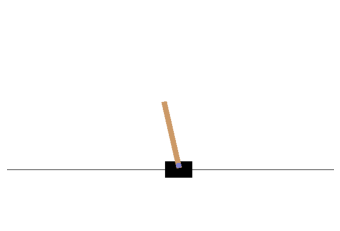

In [5]:
env = gym.make('CartPole-v1')
test_env(env)
env.close()

##### The state

The states of the cartpole task will be represented by a vector of four real numbers:

        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf


In [6]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

##### The actions available

We can perform two actions in this environment:

        0     Push cart to the left.
        1     Push cart to the right.



In [7]:
env.action_space

Discrete(2)

## Acrobot: Swing the bar up to a certain height.

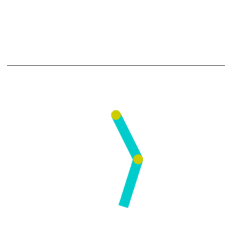

In [8]:
env = gym.make('Acrobot-v1')
test_env(env)
env.close()

##### The state

The states of the cartpole task will be represented by a vector of six real numbers. The first two are the cosine and sine of the first joint. The next two are the cosine and sine of the other joint. The last two are the angular velocities of each joint.
    
$\cos(\theta_1), \sin(\theta_1), \cos(\theta_2), \sin(\theta_2), \dot\theta_1, \dot\theta_2$

In [9]:
env.observation_space

Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)

##### The actions available

We can perform two actions in this environment:

    0    Apply +1 torque on the joint between the links.
    1    do nothing 
    2    Apply -1 torque on the joint between the links.

In [10]:
env.action_space

Discrete(3)

## MountainCar: Reach the goal from the bottom of the valley.

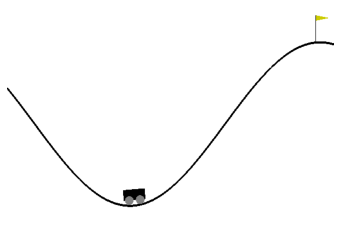

In [11]:
env = gym.make('MountainCar-v0')
test_env(env)
env.close()

##### The state

The observation space consists of the car position $\in [-1.2, 0.6]$ and car velocity $\in [-0.07, 0.07]$

In [12]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

##### The actions available


The actions available three:

    0    Accelerate to the left.
    1    Don't accelerate.
    2    Accelerate to the right.

In [13]:
env.action_space

Discrete(3)

## Pendulum: swing it and keep it upright

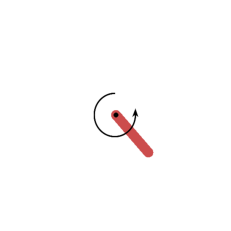

In [15]:
env = gym.make('Pendulum-v1')
test_env(env)
env.close()

##### The state

The state is represented by a vector of three values representing $\cos(\theta), \sin(\theta)$ and speed ($\theta$ is the angle of the pendulum).

In [16]:
env.observation_space

Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)

##### The actions available

The action is a real number in the interval $[-2, 2]$ that represents the torque applied on the pendulum.

In [ ]:
env.action_space

## Resources

[[1] OpenAI gym: classic control environments](https://gym.openai.com/envs/#classic_control)